# Planejamento Fatorial e Modelagem de Ajuste

Baseado nos Capítulos 3 e 5 do livro **Como Fazer Experimentos**, *de Benício de Barros Neto, Ieda Spacino Scarminio e Roy Edward Bruns* (Editora da Unicamp, 2001).

Este programa importa os dados compilados anteriormente em um arquivo `*.csv`, seguindo a lógica abaixo:
- Um arquivo `tst` é gerado pelo tribômetro para cada ensaio.
- Cada arquivo `tst` é convertido em um arquivo `csv` pelo programa *viewer* do tribômetro
- Os arquivos `csv` dos ensaios são lidos pelo programa `COF_stat_object-oriented`
    - Cada `csv` corresponde a um objeto *test*
    - Cada *test* calcula os atributos meanCOF e stdCOF, que são respectivamente coeficiente de atrito médio e o desvio padrão do coeficiente de atrito. (Obs: este coeficiente de atrito é referente a velocidade de deslizamento acima da velocidade média no ensaio recíproco, considerando a direção de deslizamento que apresentou maior coeficiente de atrito)
    - Cada material ensaiado se torna uma lista de *tests*
    - Todas as listas são compiladas em um Dataframe (tabela) e salvas em um compilado `csv`
- O compilado `csv` é aberto por este programa

Na sequência, este programa:
- Calcula os desvios padrão compostos, ou seja, considerando a variação durante o ensaio e a variação entre os ensaios com as mesmas variáveis.
- Cria um modelo empírico de COF = f(Força, % Grafite Expandido, Frequência)
- Faz uma análise de variância (ANOVA) para o modelo criado.
- Exibe os coeficientes do modelo, com intervalo de confiança, na equação do modelo
- Exibe a tabela de ANOVA, com dados sobre a qualidade do ajuste e dos dados
- Plota os gráficos dos dados e do modelo

## Importando as bibliotecas necessárias

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.cm as cmx

## Cálculo do desvio padrão composto / Variância do sistema

Decidiu-se utilizar apenas os dados dos ensaios com 30 metros de deslizamento. Destes, calculou-se o coeficiente de atrito e seu desvio padrão da seguinte forma:

- COF Médio: Média aritmética entre as médias dos ensaios
- Desvio Padrão Médio: Primeiramente, sabendo-se que a variância é dada por $Var = \frac{1}{N} \sum_{i=1}^{N} (x_i-\bar{x})^2$, pode-se expandir os termos e rearranjar para $Var = \frac{x_1^2+x_2^2+\dots+x_n^2}{n} - \bar{x}^2$. Chamaremos o termo $\frac{x_1^2+x_2^2+\dots+x_n^2}{n}$ de MQ² (média quadrática ao quadrado). Isolando MQ², temos: $MQ^2 = Var + \bar{x}^2$ Considerando que duas variâncias $Var_1$ e $Var_2$ correspondem a dois conjuntos de n elementos com médias $\bar{x}_1$ e $\bar{x}_2$, respectivamente, a variância dos dois conjuntos será $Var_{conj} = \frac{1}{2n} \sum_{i=1}^{2n} (x_i-\frac{\bar{x_1}+\bar{x_2}}{2})^2$. Expandindo e rearranjando, pode-se demonstrar que $Var_{conj} = (\frac{x_1^2+x_2^2+\dots+x_n^2}{n} + \frac{x_{n+1}^2+x_{n+2}^2+\dots+x_{2n}^2}{n})/2 - \frac{(\bar{x_1}+\bar{x_2})^2}{2}$ que pode ser representada como $Var_{conj} = \frac{MQ_1^2+MQ_2^2}{2} - \bar{x}^2$. Em termos de média e desvio padrão do coeficiente de atrito, então, temos:
$DP_{m\acute{e}dio} = \sqrt{\frac{(DP_1^2 + \overline{COF_1}^2)+(DP_2^2 + \overline{COF_2}^2)}{2} - \overline{COF}^2}$

In [5]:
# CÁLCULO DOS DESVIOS PADRÃO COMPOSTOS / VARIÂNCIA DO SISTEMA

F = 'Força Normal'
f = 'Frequência'
COF = 'COF Médio'
dp = 'COF Desv. Pad.'

df = pd.read_csv(r'C:\Users\Caio\OneDrive\Documentos\Python\Results\CSV\Compilado\df2.csv',usecols=[1,2,3,4,5,6])

PU = df[df.Material == 'PU'][df.Distância == 30].sort_values(by = ['Material','Força Normal','Frequência','Distância'])
PU = PU[[F,f,COF,dp]].reset_index()

PUEG1 = df[df.Material == 'PUEG1'].sort_values(by = ['Material','Força Normal','Frequência','Distância'])
PUEG1 = PUEG1[[F,f,COF,dp]].reset_index()

PUEG2 = df[df.Material == 'PUEG2'].sort_values(by = ['Material','Força Normal','Frequência','Distância'])
PUEG2 = PUEG2[[F,f,COF,dp]].reset_index()


materials = [PU, PUEG1, PUEG2]
matmeans = []

for mat in materials:
    forc = []
    freq = []
    coef = []
    desv = []
    for i in range(mat.shape[0]//2):
        forc.append(mat.at[2*i,F])
        freq.append(mat.at[2*i,f])
        coef.append((mat.at[(2*i),COF]+mat.at[(2*i)+1,COF])/2)
        desv.append(((mat.at[(2*i),COF]**2+mat.at[(2*i)+1,COF]**2+mat.at[(2*i),dp]**2
                            +mat.at[(2*i)+1,dp]**2)/2
                    -((mat.at[(2*i),COF]+mat.at[(2*i)+1,COF])/2)**2)**(1/2))
        # dp² = (cof_1² + dp_1² + cof_2² + dp_2²)/2 - [(cof_1+cof_2)/2]²
    matmeans.append(pd.DataFrame({F: forc, f: freq, COF: coef, dp: desv}))

PUm = matmeans[0]
PUEG1m = matmeans[1]
PUEG2m = matmeans[2]


cofs = np.asmatrix(np.concatenate((PUm[PUm['Frequência'] == 2][COF].to_numpy(),
                                   PUEG1m[PUm['Frequência'] == 2][COF].to_numpy(),
                                   PUEG2m[PUm['Frequência'] == 2][COF].to_numpy()))).T
sds = np.asmatrix(np.concatenate((PUm[PUm['Frequência'] == 2][dp].to_numpy(),
                                  PUEG1m[PUm['Frequência'] == 2][dp].to_numpy(),
                                  PUEG2m[PUm['Frequência'] == 2][dp].to_numpy()))).T
s = (12*PUm[dp].mean()+
     12*PUEG1m[dp].mean()+
     12*PUEG2m[dp].mean())/36 #desvio padrão geral, pesos de GL

C:\Users\Caio\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


## Definição do modelo de ajuste

As matrizes de cálculo são definidas aqui. **X** é a matriz de parâmetros, **Y** é a matriz de respostas e **b** é o vetor de parâmetros a ser calculado. Segue-se a equação 5.12 de Barros Neto et al. (2001), onde: $b = (X^tX)^{-1}X^tY$. Ainda de acordo com o autor, pela equação 5.30 tem-se o cálculo das variâncias de **b**, a partir da estimativa da variância do sistema ($\sigma^2$): $V(b) = (X^tX)^{-1} \sigma^2$

### Modelo

O modelo utilizado aqui é um modelo simples de interações até a terceira ordem, retiradas as interações menos relevantes, dado por:
$COF = b_0 + b_1 (\%EG) + b_2 (\%EG)^2 + b_3 F_N + b_4 f + b_5 (\%EG)f + b_6 (\%EG)F_N + b_7 F_N . f + b_8 (\%EG)F_N . f $
onde:
- $COF$: Coeficiente de atrito calculado
- $b_i$: Parâmetros do modelo, calculados a partir dos dados experimentais
- $\%EG$: Percentual de grafite expandido usado na composição do compósito
- $F_N$: Força normal aplicada no ensaio tribológico
- $f$: Frequência do movimento recíproco no ensaio tribológico

In [7]:
# INÍCIO DO CÁLCULO DA ANÁLISE DE VARIÂNCIA DO MODELO

ndf = pd.concat([df[df['Material']=='PU'].assign(**{'EG Percentage': 0}),
                 df[df['Material']=='PUEG1'].assign(**{'EG Percentage': 1}),
                 df[df['Material']=='PUEG2'].assign(**{'EG Percentage': 2})])
#atribui o número % de grafite expandido dependendo da string do material
ndf = (ndf.sort_values(by = ['Material','Força Normal','Frequência','Distância']) #ordena os ensaios de acordo com os parâmetros listados
          .dropna()) #exclui as linhas de ensaios não realizados

ndf = (ndf[ndf['Distância']==30].reset_index() #reseta os índices já reordenados
                                .drop(columns=['index'])) #apaga a coluna de índices antigos
ndf = (ndf.assign(Intercept=1) #inclui uma coluna de 'intercepto' (fatorial) para o cálculo do coeficiente b0
#Aqui devem ser incluídos os parâmetros do modelo, até o máximo de N < número de níveis usados no experimento
          .assign(**{'Força²' : ndf['Força Normal']**2}) #inclui parâmetro quadrático de força normal no modelo
          .assign(**{'EG Percentage²' : ndf['EG Percentage']**2}) #inclui um parâmetro de decaimento exponencial de porcentagem de grafite expandido
          .assign(**{'Frequência * EG Percentage' : ndf['Frequência']*ndf['EG Percentage']}) #10
          .assign(**{'Força * EG Percentage' : ndf['Força Normal']*ndf['EG Percentage']}) #11
          .assign(**{'Força * Frequência' : ndf['Força Normal']*ndf['Frequência']}) #12
          .assign(**{'Força * Frequência * EG Percentage': ndf['Força Normal']*ndf['Frequência']*ndf['EG Percentage']}) #13
          #.assign(**{'Nome do novo parâmetro': definição do novo parâmetro}) #14
          )
#_,_,f,_,_,_,b,a,e,c,g,h,i,j = ndf.columns.to_list() #adicionar novas letras ao adicionar novos parametros
P = ndf.columns.to_list()
parametros = [P[7],P[6],P[9],P[8],P[2],P[10],P[11],P[12],P[13]]

#parametros = ['Intercept',
#              'EG Percentage',
#              'EG Percentage²',
#              'Força Normal',
#              'Força²',
#              'Frequência',
#              'Frequência * EG Percentage',
#              'Força * EG Percentage',
#              'Força * Frequência',
#              'Força * Frequência * EG Percentage']

#lista de parâmetros usados, na ordem que vão aparecer na resposta b

X = np.asmatrix(ndf[parametros].to_numpy()) #matriz de parâmetros X
Y = np.asmatrix(ndf['COF Médio'].to_numpy()).T #matriz de respostas Y

b = np.dot(np.dot(np.dot(X.T,X).I,X.T),Y) #cálculo do vetor de parâmetros b 
Vb = (np.dot(X.T,X).I)*s**2 #variância/covariância dos parâmetros b, com base na variância calculada na primeira parte do programa
Vb = np.asmatrix(np.diag(Vb)).T #organizada como o vetor b (exclui covariancias)

## ANOVA

In [10]:
#cálculo das variáveis para a ANOVA
#respostas calculadas com o modelo
y_hat = 0
for i in range(len(b)):
    param = ndf[parametros]
    y_hat = y_hat + (b.item(i)*param[param.columns[i]])

#respostas médias para as repetiçoes de ensaios
y_bar = []
m = 0
for eg in ndf['EG Percentage'].unique():
    for forca in ndf['Força Normal'].unique():
        for freq in ndf['Frequência'].unique():
            if ndf[ndf['EG Percentage']==eg][ndf['Força Normal']==forca][ndf['Frequência']==freq]['COF Médio'].size>0:
                m = m+1
                for i in range(ndf[ndf['EG Percentage']==eg][ndf['Força Normal']==forca][ndf['Frequência']==freq]['COF Médio'].size):
                    y_bar.append(ndf[ndf['EG Percentage']==eg][ndf['Força Normal']==forca][ndf['Frequência']==freq]['COF Médio'].mean())
                        

p = X.shape[1] #número de parâmetros do modelo
n = ndf['COF Médio'].count() #número total de observações

SQR = ((y_hat-ndf['COF Médio'].mean())**2).sum() #soma quadrática da regressão
GLR = p-1 #graus de liberdade da regressão
MQR = SQR/GLR #média quadrática da regressão

SQr = ((ndf['COF Médio']-y_hat)**2).sum() #soma quadrática dos resíduos
GLr = n-p #graus de liberdade dos resíduos
MQr = SQr/GLr #média quadrática dos resíduos

SQep = ((ndf['COF Médio']-y_bar)**2).sum() #soma quadrática devido ao erro puro
GLep = n-m #graus de liberdade devido ao erro puro
MQep = SQep/GLep #média quadrática devido ao erro puro

SQfaj = SQr - SQep #soma quadrática devido a falta de ajuste
GLfaj = m-p #graus de liberdade devido a falta de ajuste
MQfaj = SQfaj/GLfaj #média quadrática devido a falta de ajuste

SQT = SQR+SQr #soma quadrática total
GLT = n-1 #graus de liberdade total

pve = SQR/SQT #porcentagem de variação explicada

pmve = (SQT-SQep)/SQT #porcentagem de variação máxima explicável

C:\Users\Caio\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Caio\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Caio\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Saída

In [11]:
#imprime o modelo e a ANOVA
print("""Modelo:
COF = {:.4f}±{:.5f} +
          {:.4f}±{:.5f} {} +
              {:.4f}±{:.5f} {} +
                  {:.4f}±{:.5f} {} +
                      {:.4f}±{:.5f} {} +
                          {:.4f}±{:.5f} {} +
                              {:.4f}±{:.5f} {} +
                                  {:.4f}±{:.5f} {} +
                                      {:.4f}±{:.5f} {} 
""".format(b.item(0),1.96*Vb.item(0),
          b.item(1),1.96*Vb.item(1)**(1/2),parametros[1],
          b.item(2),1.96*Vb.item(2)**(1/2),parametros[2],
          b.item(3),1.96*Vb.item(3)**(1/2),parametros[3],
          b.item(4),1.96*Vb.item(4)**(1/2),parametros[4],
          b.item(5),1.96*Vb.item(5)**(1/2),parametros[5],
          b.item(6),1.96*Vb.item(6)**(1/2),parametros[6],
          b.item(7),1.96*Vb.item(7)**(1/2),parametros[7],
          b.item(8),1.96*Vb.item(8)**(1/2),parametros[8],
          #b.item(9),1.96*Vb.item(9)**(1/2),parametros[9]
          )
    )

print( #imprime a tabela de ANOVA para o modelo
"""
Fonte de variação     Soma Quadrática      No de G. L.     Média Quadrática
Regressão             {:<7.6f}              {:<2}              {:<6.6f}
Resíduos              {:<7.6f}              {:<2}              {:<6.6f}
Falta de ajuste       {:<7.6f}              {:<2}              {:<6.6f}
Erro puro             {:<7.6f}              {:<2}              {:<6.6f}
Total                 {:<7.6f}              {:<2}               
% de variação explicada: {:.4f}
% máxima de variação explicável: {:.4f}
""".format(SQR,GLR,MQR,
           SQr,GLr,MQr,
           SQfaj,GLfaj,MQfaj,
           SQep,GLep,MQep,
           SQT,GLT,
           pve,
           pmve))

Modelo:
COF = 0.1545±0.00207 +
          -0.0340±0.08447 EG Percentage +
              0.0601±0.01835 EG Percentage² +
                  0.0016±0.00146 Força² +
                      0.0858±0.02932 Frequência +
                          -0.0499±0.02432 Frequência * EG Percentage +
                              -0.0113±0.01322 Força * EG Percentage +
                                  -0.0116±0.00502 Força * Frequência +
                                      0.0052±0.00424 Força * Frequência * EG Percentage 


Fonte de variação     Soma Quadrática      No de G. L.     Média Quadrática
Regressão             0.132245              8               0.016531
Resíduos              0.024373              27              0.000903
Falta de ajuste       0.005491              9               0.000610
Erro puro             0.018883              18              0.001049
Total                 0.156618              35               
% de variação explicada: 0.8444
% máxima de variação explicável: 0.8794


### Gráficos

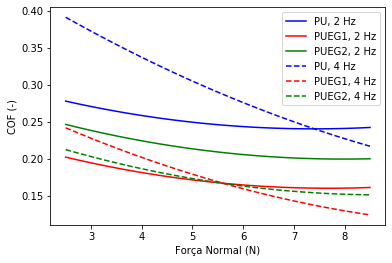

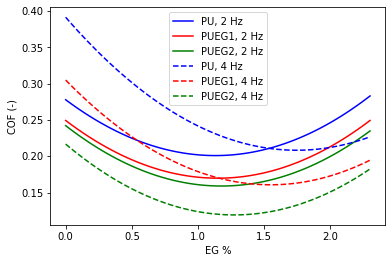

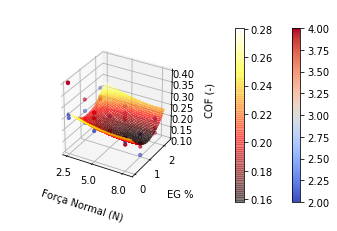

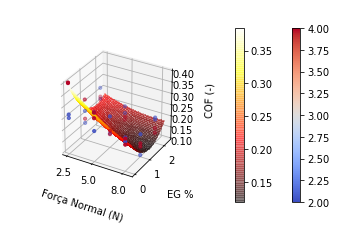

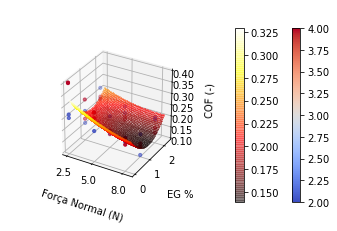

In [13]:
#função para calcular os valores nos pontos, para plotagem dos graficos
def answer(egp, freq, F):
    a = 0
    for i in range(len(b)):
        param = [1,
                 egp,
                 egp**2,
                 #F,
                 F**2,
                 freq,
                 freq * egp,
                 F * egp,
                 F * freq,
                 F * freq * egp
                 ]
        a = a + (b.item(i)*param[i])
    return a

F = np.linspace(2.5, 8.5, 100) #entradas de força de 2,5 a 8,0 N de 0,5 em 0,5N
E = np.linspace(0, 2.3, 100) #entradas de porcentagem de EG de 0 a 2 %, de 0,1 em 0,1%

#plotagem da figura, 6 graficos: 0%EG, 1%EG e 2%EG x 2Hz e 4Hz
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(F, answer(0,2,F), 'b-',label='PU, 2 Hz')
ax.plot(F, answer(1,2,F), 'r-',label='PUEG1, 2 Hz')
ax.plot(F, answer(2,2,F), 'g-',label='PUEG2, 2 Hz')
ax.plot(F, answer(0,4,F), 'b--',label='PU, 4 Hz')
ax.plot(F, answer(1,4,F), 'r--',label='PUEG1, 4 Hz')
ax.plot(F, answer(2,4,F), 'g--',label='PUEG2, 4 Hz')
ax.set_xlabel('Força Normal (N)')
ax.set_ylabel('COF (-)')
ax.legend()
plt.show()
#plotagem da figura, 6 graficos: 2,5 5,0 8,0 N x 2Hz e 4Hz
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(E, answer(E,2,2.5), 'b-',label='PU, 2 Hz')
ax.plot(E, answer(E,2,5.0), 'r-',label='PUEG1, 2 Hz')
ax.plot(E, answer(E,2,8.5), 'g-',label='PUEG2, 2 Hz')
ax.plot(E, answer(E,4,2.5), 'b--',label='PU, 4 Hz')
ax.plot(E, answer(E,4,5.0), 'r--',label='PUEG1, 4 Hz')
ax.plot(E, answer(E,4,8.5), 'g--',label='PUEG2, 4 Hz')
ax.set_xlabel('EG %')
ax.set_ylabel('COF (-)')
ax.legend()
plt.show()

def mixed3d(x,y,z, cs,x2,y2,z2,colorsMap='coolwarm'):
    cm = plt.get_cmap(colorsMap)
    cNorm = cmx.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    surf = ax.plot_surface(x2, y2, z2, cmap=cmx.hot, linewidth=0, antialiased=False,alpha=0.3)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs),s=10)
    ax.set_zlabel('COF (-)')
    ax.set_zlim(0.1,0.4)
    ax.set_ylabel('EG %')
    ax.set_xticks([2.5,5.,8.])
    ax.set_yticks([0.,1.,2.])
    ax.set_xlabel('Força Normal (N)')
    ax.xaxis.labelpad=20
    ax.yaxis.labelpad=25
    ax.zaxis.labelpad=20
    ax.dist = 15
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap, shrink = 0.8)
    fig.colorbar(surf, shrink = 0.8)
    plt.show()
    #plt.savefig('plotANOVA'+str(np.amin(z2))+'.png',dpi=300) #descomentar para salvar o arquivo do gráfico

def answer2d(egp,freq,F):
    resposta = []
    for eg in egp:
        #parametros do modelo
        P2 = np.array((1,
                       eg,
                       eg**2,
                       #F,
                       F**2,
                       freq,
                       freq*eg,
                       F*eg,
                       F*freq,
                       F*eg*freq
                       ),)
        resposta.append(np.diag(b*P2).sum())
    return np.array(resposta)

Ff,Ee = np.meshgrid(F,E)
#surface3d(tt1,tt2,cof(t1,t2))

mixed3d(ndf['Força Normal'],ndf['EG Percentage'],ndf['COF Médio'],ndf['Frequência'],Ff,Ee,answer2d(E,2,F))
mixed3d(ndf['Força Normal'],ndf['EG Percentage'],ndf['COF Médio'],ndf['Frequência'],Ff,Ee,answer2d(E,4,F))
mixed3d(ndf['Força Normal'],ndf['EG Percentage'],ndf['COF Médio'],ndf['Frequência'],Ff,Ee,(answer2d(E,2,F)+answer2d(E,4,F))/2)